In [1]:
import os, sys, json, numpy as np, tensorflow as tf
from tensorflow.contrib import predictor
from forai.settings import EXPERIMENTS_DIR
from forai.utils.estimator import (
    load_estimator_graph, lazy_fetch_variable_values, estimator_weights_names, final_model_dir,
    lazy_set_variable_values,
    pruning_dir
)
from forai.utils.matrices import prune_k_percent

In [2]:
# test loading graph functions
load_estimator_graph(final_model_dir(1))
weights = lazy_fetch_variable_values(estimator_weights_names([1000,1000,500,200]))
weights = {k: weights[k] for k in filter(lambda k: k not in ['output_layer/kernel:0'], weights)}
original_weight_matrices = weight_matrices = list(weights.values())

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/sumner/Projects/forai/forai/../experiments/1/final_model/1560941973/variables/variables
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [4]:
# test weight pruning functions
percent = 0.0
pruned_weights = prune_k_percent(weight_matrices, percent, method='weight_pruning')
pruned_units = prune_k_percent(weight_matrices, percent, method='unit_pruning')

In [3]:
def sparsity(mat):
    return len(mat.flatten().nonzero()[0]) / len(mat.flatten())

def compare(mat, prn):
    return len(mat.flatten()) * sparsity(prn), sparsity(mat), sparsity(prn)    

In [6]:
vals_1 = [compare(weight_matrices[i], pruned_weights[i]) for i in range(len(weight_matrices))]
vals_2 = [compare(weight_matrices[i], pruned_units[i]) for i in range(len(weight_matrices))]

sum([n_wts for (n_wts, mat_s, prn_s) in vals_1]), sum([n_wts for (n_wts, mat_s, prn_s) in vals_2]) 

(2384000.0, 2384000.0)

In [10]:
# assert that prune 0% results in identical weight matricies
all([(pruned_weights[i] == weight_matrices[i]).all() for i in range(len(weight_matrices))]), all([(pruned_units[i] == weight_matrices[i]).all() for i in range(len(weight_matrices))])

(True, True)

In [5]:
lazy_set_variable_values(
    dict(zip(list(weights.keys()), pruned_weights))
)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
percents_to_prune = [0.0, 0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99]
prune_methods = ['{}_pruning'.format(m) for m in ['weight', 'unit']]

In [6]:
res = {}
for method in prune_methods:
    if method not in res: res[method] = {}
    for percent in percents_to_prune:
        pruned = prune_k_percent(weight_matrices, percent, method)
        res[method][percent] = {i: sparsity(mat) for i, mat in enumerate(pruned)}
        

In [13]:
import pandas as pd, seaborn as sns

In [12]:
serialized = []
for method, percent_res in res.items():
    for percent, layer_s in percent_res.items():
        for layer, spar in layer_s.items():
            serialized.append({
                'method': method,
                'percent': percent,
                'layer': layer,
                'sparsity': spar
            })


layer          method  percent  sparsity
0       0  weight_pruning     0.00  1.000000
1       1  weight_pruning     0.00  1.000000
2       2  weight_pruning     0.00  1.000000
3       3  weight_pruning     0.00  1.000000
4       0  weight_pruning     0.25  0.752483
5       1  weight_pruning     0.25  0.767001
6       2  weight_pruning     0.25  0.730592
7       3  weight_pruning     0.25  0.657560
8       0  weight_pruning     0.50  0.500615
9       1  weight_pruning     0.50  0.500340
10      2  weight_pruning     0.50  0.498510
11      3  weight_pruning     0.50  0.499230
12      0  weight_pruning     0.60  0.399383
13      1  weight_pruning     0.60  0.393580
14      2  weight_pruning     0.60  0.406584
15      3  weight_pruning     0.60  0.436120
16      0  weight_pruning     0.70  0.297848
17      1  weight_pruning     0.70  0.287037
18      2  weight_pruning     0.70  0.314506
19      3  weight_pruning     0.70  0.373970
20      0  weight_pruning     0.80  0.197037
21      1  weight_pruning     0.80  0.180038
22      2  weight_pruning     0.80  0.222498
23      3  weight_pruning     0.80  0.310360
24      0  weight_pruning     0.90  0.096500
25      1  weight_pruning     0.90  0.073166
26      2  weight_pruning     0.90  0.129768
27      3  weight_pruning     0.90  0.246940
28      0  weight_pruning     0.95  0.046040
29      1  weight_pruning     0.95  0.019782
..    ...             ...      ...       ...
50      2    unit_pruning     0.50  1.000000
51      3    unit_pruning     0.50  1.000000
52      0    unit_pruning     0.60  0.000000
53      1    unit_pruning     0.60  0.380000
54      2    unit_pruning     0.60  1.000000
55      3    unit_pruning     0.60  1.000000
56      0    unit_pruning     0.70  0.000000
57      1    unit_pruning     0.70  0.110000
58      2    unit_pruning     0.70  1.000000
59      3    unit_pruning     0.70  1.000000
60      0    unit_pruning     0.80  0.000000
61      1    unit_pruning     0.80  0.000000
62      2    unit_pruning     0.80  0.688000
63      3    unit_pruning     0.80  0.980000
64      0    unit_pruning     0.90  0.000000
65      1    unit_pruning     0.90  0.000000
66      2    unit_pruning     0.90  0.194000
67      3    unit_pruning     0.90  0.865000
68      0    unit_pruning     0.95  0.000000
69      1    unit_pruning     0.95  0.000000
70      2    unit_pruning     0.95  0.020000
71      3    unit_pruning     0.95  0.625000
72      0    unit_pruning     0.97  0.000000
73      1    unit_pruning     0.97  0.000000
74      2    unit_pruning     0.97  0.004000
75      3    unit_pruning     0.97  0.395000
76      0    unit_pruning     0.99  0.000000
77      1    unit_pruning     0.99  0.000000
78      2    unit_pruning     0.99  0.000000
79      3    unit_pruning     0.99  0.135000

[80 rows x 4 columns]

In [14]:
df = pd.DataFrame(serialized)
df.head()

layer          method  percent  sparsity
0      0  weight_pruning     0.00  1.000000
1      1  weight_pruning     0.00  1.000000
2      2  weight_pruning     0.00  1.000000
3      3  weight_pruning     0.00  1.000000
4      0  weight_pruning     0.25  0.752483

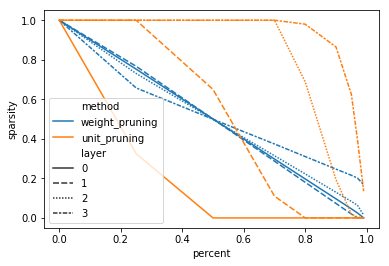

In [21]:
sns.lineplot(data=df, x="percent", y="sparsity", hue="method", style="layer")

In [22]:
df[df.percent == 0.50]

layer          method  percent  sparsity
8       0  weight_pruning      0.5  0.500615
9       1  weight_pruning      0.5  0.500340
10      2  weight_pruning      0.5  0.498510
11      3  weight_pruning      0.5  0.499230
48      0    unit_pruning      0.5  0.000000
49      1    unit_pruning      0.5  0.650000
50      2    unit_pruning      0.5  1.000000
51      3    unit_pruning      0.5  1.000000